# Confidence contours

## Prerequisites

- Knowledge of spectral analysis to produce 1D On-Off datasets, [see the following tutorial](spectrum_analysis.ipynb)
- Reading of pre-computed datasets and spectral fitting, [see the MWL tutorial](analysis_mwl.ipynb)

## Context

In most studies, one wishes to estimate parameters distribution using observed sample data.
A confidence interval gives an estimated range of values which is likely to include an unknown parameter.
The selection of a confidence level for an interval determines the probability that the confidence interval produced will contain the true parameter value.
A confidence contour is a 2D generalization of a confidence interval, often represented as an ellipsoid around the best-fit value.

**Objectives: Computation and plotting of confidence contours for parameters after a fit**

## Proposed approach

This tutorial illustrates how to fit the Crab Nebula spectrum from a HESS ON/OFF dataset, and derive confidence contours on the model parameters.


## The setup


In [1]:
import numpy as np
from astropy import units as u
import matplotlib.pyplot as plt
from gammapy.modeling import Fit, Datasets
from gammapy.modeling.models import LogParabolaSpectralModel, SkyModel
from gammapy.spectrum import SpectrumDatasetOnOff


First we define the source model, here we need only a spectral model for which we choose a log-parabola

In [2]:
crab_spectrum = LogParabolaSpectralModel(amplitude=1e-11/u.cm**2/u.s/u.TeV,
                                     reference=1*u.TeV,
                                     alpha=2.3,
                                      beta=0.2)

crab_model = SkyModel(spectral_model=crab_spectrum, name="crab")


The data and background are read from pre-computed ON/OFF datasets of HESS observations, for simplicity we stack them together.
Then we set the model and fit range to the resulting dataset.

In [3]:
datasets = []
for obs_id in [23523, 23526]:
    dataset = SpectrumDatasetOnOff.from_ogip_files(
        f"$GAMMAPY_DATA/joint-crab/spectra/hess/pha_obs{obs_id}.fits"
    )
    datasets.append(dataset)

dataset_hess = Datasets(datasets).stack_reduce(name="HESS")

# Set model and fit range
dataset_hess.models = crab_model
e_min = 0.66 * u.TeV
e_max = 30 * u.TeV
dataset_hess.mask_fit = dataset_hess.counts.energy_mask(e_min, e_max)


Now we can perform the fit using MINUIT as back-end (by default).

In [4]:
fit = Fit([dataset_hess])
result = fit.run()

After the fit, MINUIT offers the possibility to compute the confidence confours.
gammapy provides an interface to this functionnality throught the `Fit` object using the `minos_contour` method.
Here we defined a function to automatize the contour production for the differents parameterer and confidence levels (expressed in term of sigma):


In [5]:
def make_contours(fit, result, npoints, sigmas):
    cts_sigma = []
    for sigma in sigmas:
        contours = dict()
        contour = fit.minos_contour(result.parameters['alpha'], 
                                     result.parameters['beta'], 
                                     numpoints=npoints,
                                     sigma=sigma)
        contours["contour_alpha_beta"] = {
            "alpha": contour["x"].tolist(),
            "beta": (contour["y"]*np.log(10)).tolist(),
        }    

        contour = fit.minos_contour(result.parameters['amplitude'], 
                                     result.parameters['beta'], 
                                     numpoints=npoints,
                                     sigma=sigma)
        contours["contour_amplitude_beta"] = {
            "amplitude": contour["x"].tolist(),
            "beta": (contour["y"]*np.log(10)).tolist(),
        } 

        contour = fit.minos_contour(result.parameters['amplitude'], 
                                     result.parameters['alpha'], 
                                     numpoints=npoints,
                                     sigma=sigma)
        contours["contour_amplitude_alpha"] = {
            "amplitude": contour["x"].tolist(),
            "alpha": contour["y"].tolist(),
        }     
        cts_sigma.append(contours)
    return cts_sigma

Now we can compute few contours.

In [6]:
sigma = [1, 2, 3]
cts_sigma = make_contours(fit, result, 10, sigma)

/anaconda3/envs/gpy-dev/lib/python3.7/site-packages/numpy/core/fromnumeric.py:90: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/anaconda3/envs/gpy-dev/lib/python3.7/site-packages/astropy/units/quantity.py:466: RuntimeWarning: overflow encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/anaconda3/envs/gpy-dev/lib/python3.7/site-packages/astropy/units/quantity.py:466: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/anaconda3/envs/gpy-dev/lib/python3.7/site-packages/astropy/units/quantity.py:466: RuntimeWarning: overflow encountered in multiply
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/qremy/Work/GitHub/gammapy/gammapy/stats/fit_statistics.py:196: RuntimeWarning: overflow encountered in square
  D = np.sqrt(C ** 2 + 4 * alpha * (alpha + 1) * n_off * mu_sig)
/Users/qremy/

The contours lines to be plotted are obtained by interpolating the contours points.
However there is some noise in the contour points from MINUIT, which throws off most interpolation schemes.
In order to avoid this we apply a median filter to remove the outliers before the spline interpolation.
This is done by the two following functions :
 

In [7]:
def outlier_mask(data, thr=3):
    "Outliers detection using median filter"
    difference = np.abs(data - np.median(data))
    median_difference = np.median(difference)
    if median_difference == 0:
        s = 0
    else:
        s = difference / float(median_difference)
    mask = s > thr
    return mask

def plot_contour_line(ax, x, y, thr, **kwargs):
    """Plot smooth curve from points filtering outliers"""
    from scipy.interpolate import CubicSpline

    # remove outliers
    mask = outlier_mask(x, thr) | outlier_mask(y, thr)
    xf= np.array(x)[~mask]
    yf= np.array(y)[~mask]
    # close countour
    xf = np.append(xf , xf[0])
    yf = np.append(yf , yf[0])
    
    # parametrize the curve using the cumulative distance
    # of each point from the first point
    dist = np.sqrt(np.diff(xf)**2.+np.diff(yf)**2.)
    dist = [0]+list(dist)
    t = np.cumsum(dist)
    ts = np.linspace(0, t[-1], 50)
    
    # 1D cubic spline interpolation
    cs = CubicSpline(t, np.c_[xf, yf], bc_type='periodic')
    out = cs(ts)
    
    # plot
    ax.plot(out[:,0], out[:,1], "-",  **kwargs)
    ax.plot(xf, yf, '+', color=kwargs["color"])

    

In [8]:
pars = {
    "phi": {
        "label": r"$\phi_0 \,/\,(10^{-11}\,{\rm TeV}^{-1} \, {\rm cm}^{-2} {\rm s}^{-1})$",
        "lim": [2.6, 5.8],
        "ticks": [3, 4, 5],
    },
    "gamma": {
        "label": r"$\Gamma$",
        "lim": [1.9, 3.],
        "ticks": [2., 2.3, 2.6, 2.9],
    },
    "beta": {
        "label": r"$\beta$",
        "lim": [-0.1, 1.0],
        "ticks": [0.0, 0.3, 0.6, 0.9],
    },
}

panels = [
    {
        "x": "phi",
        "y": "gamma",
        "cx": (lambda ct:np.array(1e11) * ct["contour_amplitude_alpha"]["amplitude"]),
        "cy": (lambda ct: ct["contour_amplitude_alpha"]["alpha"]),
    },
    {
        "x": "phi",
        "y": "beta",
        "cx": (lambda ct: np.array(1e11) * ct["contour_amplitude_beta"]["amplitude"]),
        "cy": (lambda ct: ct["contour_amplitude_beta"]["beta"]),
    },
    {
        "x": "gamma",
        "y": "beta",
        "cx": (lambda ct: ct["contour_alpha_beta"]["alpha"]),
        "cy": (lambda ct: ct["contour_alpha_beta"]["beta"]),
    },
]

    

Finally we produce the confidence contours figures.

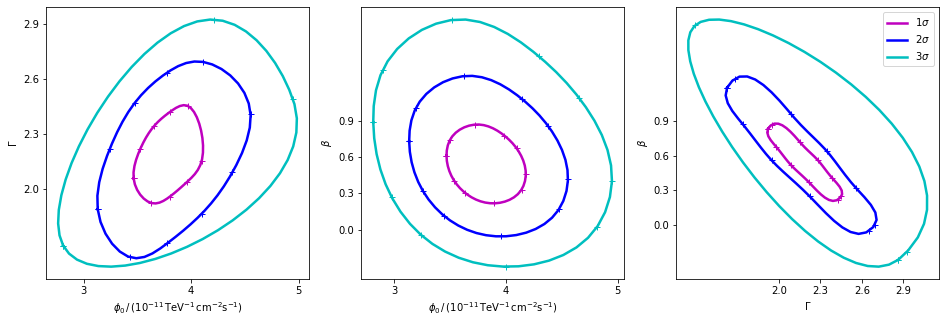

In [9]:
fig, axes = plt.subplots(1, 3, figsize=(16, 5))
colors=['m','b','c']
for p, ax in zip(panels, axes):
    x = pars[p["x"]]
    y = pars[p["y"]]
    for ks in range(len(cts_sigma)):
        plot_contour_line(ax, p["cx"](cts_sigma[ks]), p["cy"](cts_sigma[ks]), thr=2*sigma[ks], lw=2.5, color=colors[ks], label=f"{sigma[ks]}"+r"$\sigma$")
    ax.set_xlabel(x["label"])
    ax.set_ylabel(y["label"])
#    ax.set_xlim(x["lim"])
#    ax.set_ylim(y["lim"])
    ax.set_xticks(x["ticks"])
    ax.set_yticks(y["ticks"])
plt.legend()